To provide context for the recent financial performance of the company in 1H25, an image was scrapped from the companies recent announcement of key regulatory ratios and indicators of loan book health. These statistics could not be inferred from the yFinance data and thus provided unique value to the report. The image was too large for the side banner of the report, and was thus cropped.

In [694]:
import requests
from PIL import Image
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import os

# Step 1: URL of target webpage set
url = 'https://www.bendigobank.com.au/media/financial-results-for-the-half-year-ended-31-december-2024/'

# Step 2: Webpage HTML fetched using GET request
response = requests.get(url)
response.raise_for_status()

# Step 3: HTML was pared using BeautifulSoup, a Python library for stripping and handling HTML tags
soup = BeautifulSoup(response.text, 'html.parser')

# Step 4: Find the image with the specific src
target_src = '/contentassets/f4ca4760f8394c3582ce67b6a6334bbc/price-table.png'
img_tag = soup.find('img', {'src': target_src})

# Step 5: If found, build the full image URL and download
if img_tag:
    img_url = urljoin(url, img_tag['src'])  # Build absolute URL
    img_response = requests.get(img_url)
    img_response.raise_for_status()
    with open('data_table.png', 'wb') as f:
        f.write(img_response.content)

ORIGINAL_IMAGE = 'financial_results.png'
CROPPED_IMAGE = 'cropped_financial_results.png'

def crop(input_path, output_path):
    with Image.open(input_path) as img:
        width, height = img.size
        left_half = img.crop((0, 0, width // 2 - 5, height))
        left_half.save(output_path)

crop(ORIGINAL_IMAGE, CROPPED_IMAGE)

To generate the report with professional formatting, it was essential that the commentary loaded from the commentary.txt file could be formatted properly with heading, paragraphs and footers. The most intuitive solution was to write the commentary in markdown/HTML style text with heading tag, parse those tags using the html.parser package.

The bulk of the PDF was generated using the FPDF package in two distinct columns.

In [695]:
from fpdf import FPDF
from html.parser import HTMLParser
import pandas as pd

#Step 1: A PDF class is created which is used to define formatting and layout of the PDF document..
class PDF(FPDF):
    #Step 2: The header method is defined to add a header to the PDF document with the desired image and formatting.
    def header(self):
        banner_width = self.w - self.l_margin - self.r_margin
        self.image('logo.png', x=self.l_margin, y=0, w=banner_width, h=20)
        right_margin_x = self.w - self.r_margin
        x_text_start = right_margin_x - 60  # Adjust as needed
        y_text_start = 4  # Top padding from banner top
        
        #Step 3: The recommendation is drawn over the banner image with a specific font and color.
        #Line 1: "Recommendation: "
        self.set_y(25)
        self.set_xy(x_text_start, y_text_start)
        self.set_font('Arial', 'B', 12)
        self.set_text_color(255,255,255)  # White
        self.cell(self.get_string_width("Recommendation: "), 7, "Recommendation: ", ln=0)

        self.set_text_color(255, 204, 0)  # Yellow
        self.set_font('Arial', 'B', 12)
        self.cell(0, 7, "HOLD", ln=1)

        # Line 2: "Downside: -1.39%"
        self.set_text_color(255,255,255)
        self.set_font('Arial', 'B', 12)
        self.set_x(x_text_start)
        self.cell(0, 6, "Downside: -1.39%", ln=1)
        self.set_text_color(0)
        self.set_y(25)
    #Step 4: A footer method is defined to add a footer to the PDF document with the page number.
    def footer(self):
        self.set_y(-12)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 8, f'Page {self.page_no()}', align='C')

#Here, the HTMLParser class is defined to handle the parsing of the markdown tags and translate them to formatting in the PDF.
class ColumnHTMLParser(HTMLParser):
    #All methods inheret the same functionality defined in __init__ method.
    def __init__(self, pdf, x, y, col_width, line_height=5):
        super().__init__()
        self.pdf = pdf
        self.x = x
        self.y = y
        self.col_width = col_width
        self.line_height = line_height
        self.current_tag = None
        self.pdf.set_xy(x, y)

    #Logic is implimented to handle the start and end of HTML tags to change formatting
    def handle_starttag(self, tag, attrs):
        self.current_tag = tag
        if tag == 'h1':
            self.pdf.set_font('Arial', 'B', 14)
            self.pdf.set_xy(self.x, self.pdf.get_y())
        elif tag == 'h2':
            self.pdf.set_font('Arial', 'B', 12)
            self.pdf.set_xy(self.x, self.pdf.get_y())
        elif tag == 'p':
            self.pdf.set_font('Arial', '', 10)
            self.pdf.set_xy(self.x, self.pdf.get_y())
    #Logic is implimented to handle the end of HTML tags to change formatting.
    def handle_endtag(self, tag):
        if tag == 'p':
            self.pdf.ln(2)
        if self.current_tag == 'h1':
            self.pdf.ln(2)
        if self.current_tag == 'h2':
            self.pdf.ln(2)
        self.current_tag = None
    #Logic is implimented to handle the content within the HTML tags to change formatting (e.g. line height)
    def handle_data(self, data):
        if self.current_tag:
            self.pdf.multi_cell(self.col_width, self.line_height, data)
            self.pdf.set_x(self.x)



# Set up PDF
pdf = PDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()

# Column dimensions
total_width = pdf.w - pdf.l_margin - pdf.r_margin
col1_w = total_width * 2 / 3
col2_w = total_width * 1 / 3
line_height = 5

# Starting position after header
y_start = pdf.get_y()


The right hand column content consisted of serveral images and a blue highlight banner.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'Dividend Yield (%)': np.float64(2.69), 'Earnings Per Share (EPS)': 0.96, 'Price to Earnings (P/E)': np.float64(11.58), 'Return on Assets (ROA %)': np.float64(0.55), 'Return on Equity (ROE %)': 7.68, 'Profit Margin (%)': 27.03, 'Operating Margin (%)': 33.38, 'Price to Book (P/B)': np.float64(0.89), 'Dividend Payout Ratio (%)': 31.19}


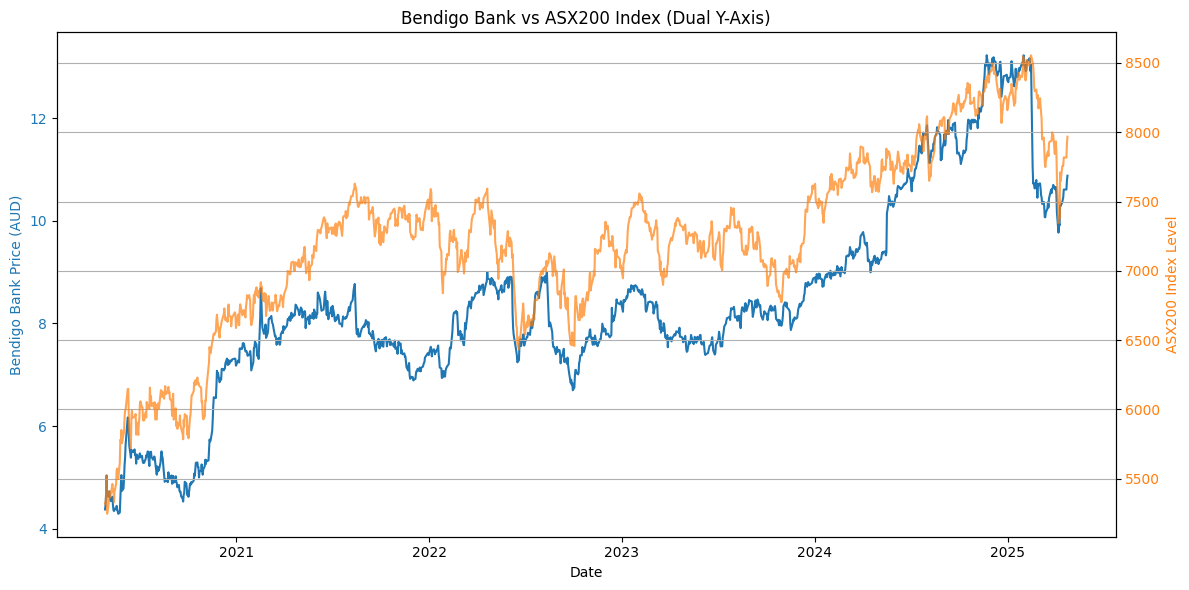

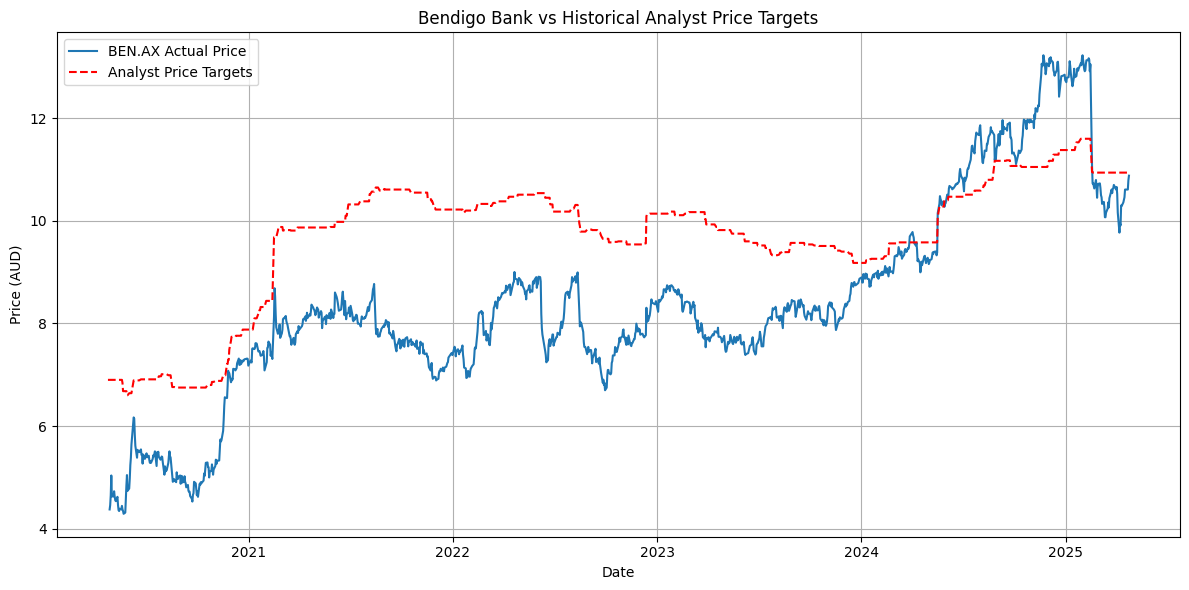

In [696]:
from openpyxl import load_workbook
# Right column content
# Set the starting position for the right column
x_right = pdf.l_margin + col1_w + 5  # Start of right column
y_right_start = y_start
col2_actual_width = col2_w - 5  # Narrow a little for margin space

# Set light blue color for the highlight background
pdf.set_fill_color(230, 240, 255)  # Very light blue

# Draw the rectangle
pdf.rect(x_right, y_right_start, col2_actual_width, 350, style='F')
pdf.set_xy(pdf.l_margin + col1_w + 5, y_start)
right_x = pdf.get_x()
right_y = pdf.get_y()

# First figure is a table from the DDM model, so specific cells from this are loaded using openpyxl into a dataframe.
wb = load_workbook('BENDIGO.xlsx', data_only=True)
ws = wb.active

# Now manually read D9:J13 and D17:J19 preserving formatting
data = []
rows_to_extract = list(range(9, 14)) + list(range(17, 20))

for i in rows_to_extract:
    label = str(ws.cell(row=i, column=4).value or '').strip()  # Column D
    unit = str(ws.cell(row=i, column=5).value or '').strip()   # Column E
    value_cell = ws.cell(row=i, column=10)  # Column J
    value = value_cell.value
    fmt = value_cell.number_format

    # Each cell's value is extracted and formatted based on the type of data it contains (e.g. percentages have % added)
    if value is None:
        display = ''
    elif isinstance(value, (int, float)):
        if '%' in fmt or fmt.endswith('%') or unit == '[%]':
            display = f"{value * 100:.2f}%"
        elif '$' in fmt or 'Accounting' in fmt or unit == '[$]':
            display = f"${value:,.2f}"
        elif unit == '[m]':
            display = f"{value:,.0f}m"
        elif ',' in fmt or '#,##0' in fmt:
            display = f"{value:,.0f}"
        elif 'Intrinsic' in label or 'Share Price' in label:
            display = f"${value:.2f}"
        elif 'Discount' in label:
            display = f"{value * 100:.2f}%"
        else:
            display = f"{value:.2f}"
    else:
        display = str(value)

    data.append([label, display])

df = pd.DataFrame(data)

pdf.set_xy(pdf.l_margin + col1_w + 10, y_start)
right_x = pdf.get_x()
right_y = pdf.get_y()

pdf.set_font('Arial', '', 5)

col_width = (col2_w - 10 ) / df.shape[1]  # number of columns
row_height = 5
pdf.set_y(right_y + 10)

df.columns = ["Metric", "Value"]
pdf.set_x(right_x-2.5)
right_x = pdf.get_x()

# Header row is added to table
pdf.set_font('Arial', 'B', 6)  # Bold font
for col_name in df.columns:
    pdf.cell(col_width, row_height, str(col_name), border='B', align='C')
pdf.ln(row_height)
pdf.set_x(right_x)

#All other rows added to table
pdf.set_font('Arial', '', 6)  # Back to normal font
for i in range(len(df)):
    for j in range(len(df.columns)):
        value = str(df.iloc[i, j])
        pdf.cell(col_width, row_height, value, border='B', align='C')
    pdf.ln(row_height)
    pdf.set_x(right_x)

right_x = pdf.get_x()
right_y = pdf.get_y()

# Load image into right column
image_width = col2_w - 10  # leave small gap

# Move cursor after the image
pdf.set_y(right_y - 30)  # Adjust 50 to be the height of your image (approx.)
pdf.image('cropped_financial_results.png', x=right_x, y=right_y+5.5, w=image_width)

pdf.set_y(right_y+35)  # Adjust 50 to be the height of your image (approx.)
pdf.set_x(right_x+10)
right_x = pdf.get_x()
right_y = pdf.get_y()


from Ratios_and_Metrics import financial_metrics_bendigo

df = financial_metrics_bendigo()

# Adjusted total table width
table_width = col2_w - 10
col_width = table_width / df.shape[1]

# Starting X position with 5 padding on each side
table_start_x = right_x - 10
pdf.set_x(table_start_x)

# --------- Draw HEADER row ----------
pdf.set_font('Arial', 'B', 6)
for col_name in df.columns:
    pdf.cell(col_width, row_height, str(col_name), border='B', align='C')
pdf.ln(row_height)

# --------- Draw BODY rows ----------
pdf.set_font('Arial', '', 6)
for i in range(len(df)):
    pdf.set_x(table_start_x)  # Reset to start of row each line
    for j in range(len(df.columns)):
        value = str(df.iloc[i, j])
        pdf.cell(col_width, row_height, value, border='B', align='C')
    pdf.ln(row_height)

from Stock_Price_Chart import plot_stock_price_chart
plot_stock_price_chart()

pdf.set_x(table_start_x)
right_y = pdf.get_y()
right_x -= 10
right_y += 5.5

pdf.set_y(right_y - 30)  # Adjust 50 to be the height of your image (approx.)
pdf.image('bendigo_vs_asx200.png', x=right_x, y=right_y, w=image_width)

right_y += 60
pdf.set_y(right_y)  # Adjust 50 to be the height of your image (approx.)
pdf.image('bendigo_vs_targets.png', x=right_x, y=right_y, w=image_width)



# --- Group member list: positioned relative to table, move as a block ---
pdf.set_font('Arial', 'I', 6)

# Set these two values to control the block position
group_top_y = pdf.get_y() + 65     # vertical position (↓ = larger number)
group_left_x = table_start_x + 12   # horizontal position (→ = larger number)

# Move to starting position
pdf.set_xy(group_left_x, group_top_y)

# Group members
group_members = [
    "Hugh ODonnell - 4740073",
    "Miles Mizutani - 43127890",
    "Jason Lee - 43216789",
    "Emily Tran - 42896543"
]

line_height = 4
#for member in group_members:
    #pdf.set_x(group_left_x)
    #pdf.cell(0, line_height, member, ln=True)

Left column content

NameError: name '__file__' is not defined

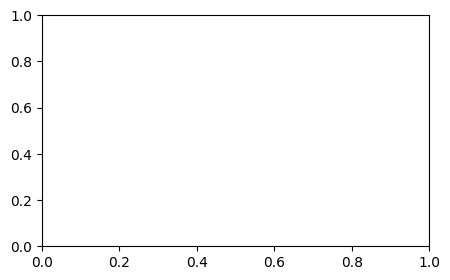

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import os
def plot_stock_price_chart():
    plt.close('all')  # at the beginning of your function
    fig, ax = plt.subplots(figsize=(5, 3))
    # --- Set working directory to script location ---
    script_dir = os.path.dirname(os.path.abspath(__file__))
    os.chdir(script_dir)

    # --- Set date range ---
    start_date = "2020-04-25"
    end_date = "2025-04-25"

    # --- Download stock data ---
    bendigo = yf.download("BEN.AX", start=start_date, end=end_date)
    asx200 = yf.download("^AXJO", start=start_date, end=end_date)

    # --- Load and prepare historical price target CSV ---
    price_targets = pd.read_csv("Historical_Price_Targets.csv", parse_dates=["Date"])
    for col in price_targets.columns:
        if col != "Date":
            price_targets = price_targets.rename(columns={col: "Target Price"})
            break
    price_targets = price_targets.sort_values("Date")

    # --- Plot 1: BEN.AX vs ASX200 (with dual y-axes) ---
    fig, ax1 = plt.subplots(figsize=(5, 5))  # Square aspect

    ax1.plot(bendigo["Close"], color='tab:blue', label="BEN.AX")
    ax1.set_ylabel("BEN.AX (AUD)", fontsize=9, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=8)
    ax1.tick_params(axis='x', labelsize=8)

    ax2 = ax1.twinx()
    ax2.plot(asx200["Close"], color='tab:orange', label="ASX200", alpha=0.7)
    ax2.set_ylabel("ASX200", fontsize=9, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=8)

    ax1.set_title("BEN vs ASX200", fontsize=10)
    ax1.set_xlabel("Date", fontsize=9)

    fig.tight_layout(pad=1.0)
    plt.grid(True, linewidth=0.4)
    plt.savefig("bendigo_vs_asx200.png", dpi=300)

    # --- Plot 2: BEN.AX vs Analyst Price Targets ---
    fig2, ax = plt.subplots(figsize=(5, 5))

    ax.plot(bendigo["Close"], label="BEN.AX", linewidth=1)
    ax.plot(price_targets["Date"], price_targets["Target Price"],
            color='red', label="Analyst Targets", linestyle='--', linewidth=1)

    ax.set_title("BEN vs Analyst Targets", fontsize=10)
    ax.set_xlabel("Date", fontsize=9)
    ax.set_ylabel("Price (AUD)", fontsize=9)
    ax.tick_params(labelsize=8)
    ax.legend(fontsize=8)
    ax.grid(True, linewidth=0.4)

    fig2.tight_layout(pad=1.0)
    plt.savefig("bendigo_vs_targets.png", dpi=300)

    return None

plot_stock_price_chart()

In [697]:
# Load the commentary from file
with open("commentary.txt", "r", encoding="utf-8") as f:
    html_content = f.read()

# --------- LEFT COLUMN (Formatted HTML) ---------
pdf.set_xy(pdf.l_margin, y_start)
html_parser = ColumnHTMLParser(pdf, x=pdf.l_margin, y=y_start, col_width=col1_w, line_height=line_height)
html_parser.feed(html_content)
y_left_end = pdf.get_y()
y_right_end = pdf.get_y()

# Ensure bottom spacing is correct
pdf.set_y(max(y_left_end, y_right_end) + 5)

# Save it
pdf.output('BEN.pdf')

''

In [698]:
import requests
from bs4 import BeautifulSoup

# Reading in AFR URL for Bendigo Website
AFR = 'https://www.afr.com/company/asx/ben'
RawHTML = requests.get(AFR)

# Parse the raw HTML using BeautifulSoup
parse = BeautifulSoup(RawHTML.content, 'html.parser')

# Find recent AFR headlines by filtering to publication-specific format
headlines = parse.find_all('h3', class_='-_73414cb90844eda9-headline')

# Pull and print the most recent 10 headlines
for headline in headlines[:10]:
    print(headline.get_text(strip=True))

Banks campaign for cash levy to avoid Armaguard ‘monopoly’
Slash stamp duty to encourage retirees to downsize: ING
Bank profit falls send uneasy investors into panic mode
The ASX queries Bendigo Bank’s disclosures after share price tumble
What we learnt: Investors just handed out the biggest beating of profit season
Surge in Bendigo Bank lending crunches margins, sends shares sliding
Westpac boss supports RBA rate cut, says it will deliver needed relief
Banks would face new loan regime under Coalition amid ESG pushback
Credit to Chalmers for non-partisan RBA picks
Macquarie, Westpac and CBA big losers from $350m rural bank levy
